<h1 align='center'>Crop Image Detection Using Faster R-CNN</h1>

## Contents

- [Problem Statement](#problem-statement)
- [About Data](#about-data)
- [Approach](#approach)
- [File Structure](#file-structure)
- [Instllations](#installations)
- [Imports](#imports)
- [Data Loading](#data-loader)
- [Exploratory Data Analysis(EDA)](#exploratory-data-analysiseda)
- [Data Preprocessing/Cleaning](#data-preprocessing)
- [Dataset and DataLoader](#dataset-and-dataloader)
- [Modeling](#modeling)
- [Model Finetuning](#model-finetuning)
- [Model Evaluation](#model-evaluation)
- [Model Testing](#model-testing)
- [Save Weights](#save-weights)

## Problem Statement

Train an object detection algorithm , preferably Faster-RCNN to identify the crop type in the image.



## About Data

**Given files:**

- `images` - Contains image of different crop types
- `crop_object_detection_annot.csv` - Contains following info

    - `label_name` - Crop type
    - `bbox_x` - leftmost bottommost x coordinate of crop
    - `bbox_y` - leftmost bottommost y coordinate of crop
    - `bbox_width` - width of the crop image
    - `bbox_height` - hight of the crop image
    - `image_name` - Name of the snapshot image
    - `image_width` - width of the overall image
    - `image_height` - height of the overall image


## Approach

I will be using `Faster R-CNN` model to do crop detection. It is much faster than its predicessor like `R-CNN` and `Fast R-CNN`

Since we don't have much training data it makes sense to use some pretrained models. I will be using `fasterrcnn_resnet50_fpn` model with weight of `COCO_V1`. 

Finetuning will be done with existing train data.

## File Structure

This is an overview of the project's file and folder structure:

```
project-root/
│
├── training_dataset/
│ ├── images/
│ ├── crop_object_detection_annot.csv

```

## Installations


In [182]:
#!pip install torch

## Imports

In [183]:
import sys
import shutil
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import os
from PIL import Image

import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms.functional as F
from tqdm import tqdm
from torchvision.ops import nms

import pickle
import glob as glob
import random

## Data Loader

**csv file**

In [184]:
df = pd.read_csv("training_dataset/crop_object_detection_annot.csv")

df.head()

,label_name,bbox_x,bbox_y,bbox_width,bbox_height,image_name,image_width,image_height
0,black gram,11,224,1188,461,Pramod_gt_20211215_101234838.jpg,1200,900
1,turmeric,335,442,612,250,Pramod_gt_20211215_101416555.jpg,1200,900
2,turmeric,14,265,1186,548,Pramod_gt_20211215_101650737.jpg,1200,900
3,maize,3,263,1191,632,Pramod_gt_20211215_101933185.jpg,1200,900
4,turmeric,3,268,1197,422,Pramod_gt_20211215_102352478.jpg,1200,900


**Images**

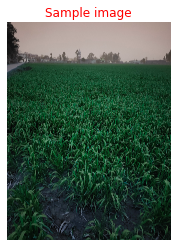

In [185]:
#load a sample image

img = cv2.imread("training_dataset/images/35472bb3-d85f-11e9-90fc-b7cb9a623b4e$$9f7abad2-ec2b-11e9-b6f4-e3190c0dc32e$$13a51ab8-f192-4393-b513-b358dde645fd.jpg",  cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.title('Sample image', color = 'red')
plt.axis('off')
plt.show()

## Exploratory Data Analysis(EDA)

In this section, we will look at following 
- Total number of unique crops
- Frequency count of each crop in train set
- Is there any image with two crops in it
- Largest and Smallaest image  by size
- Visulaize sample images with bounding boxes


In [186]:
#total number of rows in train set
print(f"Total Number of Rows in Train are : {df.shape[0]}")
print(f"Total Number of Rows in Test are : {df.shape[1]}")

Total Number of Rows in Train are : 607
Total Number of Rows in Test are : 8


In [187]:
#columns name
df.columns

Index(['label_name', 'bbox_x', 'bbox_y', 'bbox_width', 'bbox_height',
       'image_name', 'image_width', 'image_height'],
      dtype='object')

In [188]:
#data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   label_name    607 non-null    object
 1   bbox_x        607 non-null    int64 
 2   bbox_y        607 non-null    int64 
 3   bbox_width    607 non-null    int64 
 4   bbox_height   607 non-null    int64 
 5   image_name    607 non-null    object
 6   image_width   607 non-null    int64 
 7   image_height  607 non-null    int64 
dtypes: int64(6), object(2)
memory usage: 38.1+ KB


Data type seems correct for all the features.

In [189]:
#frequenct counts
df[['label_name']].value_counts()

label_name
turmeric      151
sugarcane     100
mustard        86
maize          65
chilli         57
black gram     54
wheat          45
Paddy          40
potato          8
green gram      1
dtype: int64

- Most of the images of of `turmeric` followd by `sugercane` and `mustard`. We have only one instance of `green gram` in entire trainset. 

In [190]:
#let's check if we have uniqiue ocuurance of each image
df[['image_name']].value_counts()

image_name                         
Samanth_gt_20211215_112452038.jpg      7
Samanth_gt_20211215_111842903.jpg      5
Pramod_gt_20211216_100013486.jpg       4
Pramod_gt_20211216_100828620.jpg       4
Saptarshi_gt_20211215_173929495.jpg    4
                                      ..
Pramod_gt_20211216_111541683.jpg       1
Pramod_gt_20211216_111415010.jpg       1
Pramod_gt_20211216_100124496.jpg       1
Pramod_gt_20211216_095944602.jpg       1
index3.jpg                             1
Length: 487, dtype: int64

Okay we have some images with multiple crops. lets check if it is present in `img` folder and if so lets visualize it.

In [191]:
img_files = set(os.listdir("training_dataset/images/"))
print(f"Total number of images are {len(img_files)}")

Total number of images are 487


Is there any image which name is there in csv file but in img folder.

In [192]:
images_in_df = set(df['image_name'])

print(f"Number of images that are in img folder but their name is not in csv files : {len(img_files.difference(images_in_df))}")

print(f"Number of images that are not in img folder but their name is in csv files : {len(images_in_df.difference(img_files))}")


Number of images that are in img folder but their name is not in csv files : 0
Number of images that are not in img folder but their name is in csv files : 0


In [193]:
img_files.difference(images_in_df)

set()

These images are in image folder but we don't have any info regarding them in the meta data csv. We can ignore the from our analysis.

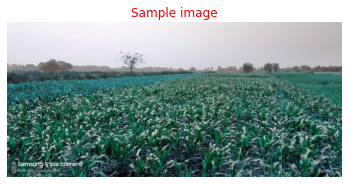

In [194]:
#image with multiple crops in it

multi_crop_img = cv2.imread("training_dataset/images/Samanth_gt_20211215_112452038.jpg",  cv2.COLOR_BGR2RGB)

plt.imshow(multi_crop_img)
plt.title('Sample image', color = 'red')
plt.axis('off')
plt.show()

Lets look at the crops present in this image.

In [195]:
df.query("image_name=='Samanth_gt_20211215_112452038.jpg'")['label_name'].tolist()

['maize', 'maize', 'maize', 'maize', 'turmeric', 'mustard', 'mustard']

So we have `maize`, `turmeric` and `mustard` crops in the above image.

In [196]:
df.columns

Index(['label_name', 'bbox_x', 'bbox_y', 'bbox_width', 'bbox_height',
       'image_name', 'image_width', 'image_height'],
      dtype='object')

In [197]:
#biggest image and smalles image by size
df['image_size'] = df['image_width']*df['image_height']

min(df['image_size'].tolist()), max(df['image_size'].tolist())

(48440, 48000000)

In [198]:
df.columns

Index(['label_name', 'bbox_x', 'bbox_y', 'bbox_width', 'bbox_height',
       'image_name', 'image_width', 'image_height', 'image_size'],
      dtype='object')

## Data Preprocessing

In this step we will be doing following:

- Remove the images for which we don't have meta data info
- Remove special characters from image name
- Add `x_max`, `y_max` and rename `bbox_x` and `bbox_y` to `x_min` and `y_min` for better understanding
- Resize the images and its bounding boxes by `224X224`

**Remove special characters**

In [199]:
df['image_name'] = df['image_name'].str.replace("$", "")

base_path = "training_dataset/"

new_path  = base_path+"cleaned_images/"
prev_path = base_path+"images/"

if "cleaned_images" not in os.listdir(base_path):
    os.mkdir(new_path)

for img_name in os.listdir(path="training_dataset/images/"):

    shutil.copy(prev_path+img_name, new_path+img_name.replace("$", ""))


/var/folders/xf/gcbfh98s6n53wh5f2hpb84nh0000gn/T/ipykernel_20647/3787924777.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['image_name'] = df['image_name'].str.replace("$", "")


**Remove the images for which we do not have meta data info**


In [200]:
images_in_df = set(df['image_name'])

img_files = set(os.listdir(new_path))

for img in img_files.difference(images_in_df):

    os.remove(new_path+img)

**Add and rename columns**

In [201]:
finaldf = df.rename(columns={"bbox_x":"x_min", "bbox_y":"y_min"})
finaldf['x_max'] = finaldf['x_min'] + finaldf['bbox_width']
finaldf['y_max'] = finaldf['y_min'] + finaldf['bbox_height']

finaldf.head()

,label_name,x_min,y_min,bbox_width,bbox_height,image_name,image_width,image_height,image_size,x_max,y_max
0,black gram,11,224,1188,461,Pramod_gt_20211215_101234838.jpg,1200,900,1080000,1199,685
1,turmeric,335,442,612,250,Pramod_gt_20211215_101416555.jpg,1200,900,1080000,947,692
2,turmeric,14,265,1186,548,Pramod_gt_20211215_101650737.jpg,1200,900,1080000,1200,813
3,maize,3,263,1191,632,Pramod_gt_20211215_101933185.jpg,1200,900,1080000,1194,895
4,turmeric,3,268,1197,422,Pramod_gt_20211215_102352478.jpg,1200,900,1080000,1200,690


In [202]:
images_in_df = set(df['image_name'])
img_files = set(os.listdir(new_path))

print(f"Number of images that are in img folder but their name is not in csv files : {len(img_files.difference(images_in_df))}")
print(f"Number of images that are not in img folder but their name is in csv files : {len(images_in_df.difference(img_files))}")


Number of images that are in img folder but their name is not in csv files : 0
Number of images that are not in img folder but their name is in csv files : 0


**Remove the invalid bouding boxes**
- `x_max` should not be greater than `image_width`
- `y_max` should not be greater than `image_breadth`
- `x_max` and `x_min` should not be equal
- `y_max` and `y_min` should not be equal

In [203]:
print(f"df size is {len(finaldf)}")

finaldf = finaldf.query("x_max <= image_width and y_max <= image_height")
finaldf = finaldf.query("x_max != x_min and y_min !=y_max")
print(f"df size is {len(finaldf)}")

df size is 607
df size is 607


We don't have any invalid images.

**Resizing Images and Bounding Boxes**

In [204]:
#resizing function

def resize_image_with_bbox(img_path, img_width, img_height, target_size):

    img = cv2.imread(img_path,  cv2.COLOR_BGR2RGB)
    x_scale = target_size / img_width
    y_scale = target_size / img_height
    img = cv2.resize(img, (target_size, target_size))
    
    return (img, x_scale, y_scale)



In [205]:
finaldf.columns

Index(['label_name', 'x_min', 'y_min', 'bbox_width', 'bbox_height',
       'image_name', 'image_width', 'image_height', 'image_size', 'x_max',
       'y_max'],
      dtype='object')

In [206]:
base_path = "training_dataset/cleaned_images/"
new_path = "training_dataset/cleaned_resized_images/"

if "cleaned_resized_images" not in os.listdir("training_dataset/"):
    os.mkdir(new_path)

x_min_resized = []
y_min_resized = []
x_max_resized = []
y_max_resized = []

for _, row in finaldf.iterrows():
    img_path = base_path+row['image_name']
    image_width = row['image_width']
    image_height = row['image_height']
    img, x_scale, y_scale = resize_image_with_bbox(img_path, image_width, image_height, 224)
    x_min = row['x_min']
    x_max = row['x_max']
    y_min = row['y_min']
    y_max = row['y_max']
    x_min_resized.append(int(np.round(x_min * x_scale)))
    y_min_resized.append(int(np.round(y_min * y_scale)))
    x_max_resized.append(int(np.round(x_max * x_scale)))
    y_max_resized.append(int(np.round(y_max * y_scale)))
    #write resized image
    cv2.imwrite(new_path+row['image_name'], img)

finaldf['x_min_resized'] = x_min_resized
finaldf['y_min_resized'] = y_min_resized
finaldf['y_max_resized'] = y_max_resized
finaldf['x_max_resized'] = x_max_resized
    

In [207]:
print(f"df size is {len(finaldf)}")

finaldf1 = finaldf.query("x_max_resized <= 224 and y_max_resized <= 224")
finaldf2 = finaldf.query("x_max_resized != x_min_resized and y_min_resized !=y_max_resized")
#get the list of images not satisfying the above condition
invalid_images = set(finaldf['image_name']).difference(set(finaldf1['image_name'])).union(set(finaldf['image_name']).difference(set(finaldf2['image_name'])))
print(invalid_images)
for i in invalid_images:
    print(i)
    os.remove(new_path+"/"+i)

finaldf = finaldf.query("x_max_resized <= 224 and y_max_resized <= 224").query("x_max_resized != x_min_resized and y_min_resized !=y_max_resized")
print(f"df size is {len(finaldf)}")

df size is 607
{'35472bb3-d85f-11e9-90fc-b7cb9a623b4e9f7abaf7-ec2b-11e9-b6f4-697f5aae065f7b79a9b1-59b1-4423-9efd-05e8e1276685.jpg'}
35472bb3-d85f-11e9-90fc-b7cb9a623b4e9f7abaf7-ec2b-11e9-b6f4-697f5aae065f7b79a9b1-59b1-4423-9efd-05e8e1276685.jpg
df size is 606


In [208]:
images_in_df = set(finaldf['image_name'])
img_files = set(os.listdir(new_path))

print(f"Number of images that are in img folder but their name is not in csv files : {len(img_files.difference(images_in_df))}")
print(f"Number of images that are not in img folder but their name is in csv files : {len(images_in_df.difference(img_files))}")


Number of images that are in img folder but their name is not in csv files : 0
Number of images that are not in img folder but their name is in csv files : 0


## Data Augmentation

Since dataset size is not that large, It makes sense to use data augmentation for better training and predictions.

I have used following data augmentation techniques
- Image to Tensor 
- Contrast and Brightness adjustment 
- Horizontal flipping


In [209]:
'''
Class that holds all the augmentation related attributes
'''
class Transformation():
    # to apply a transformation or not
    def get_probability(self):
        return np.random.choice([False, True], replace=False, p=[0.5, 0.5])

    # Increases the contrast
    def random_adjust_contrast(self, image,enable=None, threshold = 2):
        enable = self.get_probability() if enable is None else enable
        return F.adjust_contrast(image, 2) if enable else image

    # Increaes the brightness
    def random_adjust_brightness(self, image, enable=None, threshold = 2):
        enable = enable = self.get_probability() if enable is None else enable
        return F.adjust_brightness(image,2) if enable else image

    # Horizontal flip
    def random_hflip(self, image, boxes, enable=None):
        enable = enable = self.get_probability() if enable is None else enable
        if enable:
          #flip images and bozes as well
          new_image = F.hflip(image)
          new_boxes = boxes.clone()
          new_boxes[:, 0] = image.shape[2] - boxes[:, 0]  
          new_boxes[:, 2] = image.shape[2] - boxes[:, 2] 
          new_boxes = new_boxes[:, [2, 1, 0, 3]]       
          return new_image, new_boxes
        else:
          return image, boxes

## Dataset and DataLoader

To process data in batches I am using `pytorch` dataset and dataloader. Lets define a custom datasets for this crop data having some elementatry methods

**Dataset**

In [161]:
class cropCustomDataset(Dataset):

  def __init__(self, img_path, meta_info, classes, transforms=None):

    super().__init__()
    print("Intializing...")

    self.image_dir = img_path
    self.meta_info = meta_info
    self.classes = classes
    self.transforms = transforms
    self.image_paths = glob.glob(f"{img_path}/*.jpg")
    print(len(self.image_paths))
    all_images = [image_path.split(os.path.sep)[-1] for image_path in self.image_paths]
    self.all_images = sorted(all_images)

    #encode labels to their index in classes variable
    for i in self.meta_info.index:
      label = self.meta_info.loc[i, 'label_name']
      self.meta_info.loc[i, 'label_name'] = self.classes.index(label)

    print("Dataset Prepared...")

    #for getting item by their index
  def __getitem__(self, idx):

    target = {}

    # Read input image
    image_name = self.all_images[idx]
    image_path = os.path.join(self.image_dir, image_name)
    image = cv2.imread(image_path)
    #normalize img
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0
    image = torch.from_numpy(image).permute(2,0,1)

    # Fetch meta data for given image
    meta_info = self.meta_info[self.meta_info['image_name'] == image_name]
    assert len(meta_info) != 0
    boxes = torch.Tensor(meta_info[['x_min_resized', 'y_min_resized', 'x_max_resized', 'y_max_resized']].values).float()
    labels = torch.LongTensor(meta_info['label_name'].values.tolist())
    #incase transformation is enabled
    if self.transforms:
        image = self.transforms.random_adjust_contrast(image, enable=True)
        image = self.transforms.random_adjust_brightness(image, enable=True)
        image, boxes = self.transforms.random_hflip(image, boxes, enable=True)

    target["boxes"] = boxes   
    target["labels"] = labels

    return image, target

  def __len__(self):
    return len(self.all_images)


Lets test the above functions - Sanity check

In [162]:
len(finaldf.copy())

606

In [163]:
classes = sorted(list(set(finaldf['label_name'])))
img_dir = "training_dataset/cleaned_resized_images"
dataset = cropCustomDataset(img_dir, finaldf.copy(), classes, transforms=None)


Intializing...
486
Dataset Prepared...


## Plotting Images

Lets define a function which can be used to plot images along with bouding boxes and corresponding labels.

In [164]:
import matplotlib.patches as patches

def plot_image(img, boxes, scores, labels, classes, save_path=None):

  cmap = plt.get_cmap("tab20b")
  class_labels = np.array(classes)
  colors = [cmap(i) for i in np.linspace(0, 1, len(class_labels))]
  height, width, _ = img.shape
  # Create figure and axes
  fig, ax = plt.subplots(1, figsize=(16, 8))
  # Display the image
  ax.imshow(img)
  for i, box in enumerate(boxes):
    class_pred = labels[i]
    conf = scores[i]
    width = box[2] - box[0]
    height = box[3] - box[1]
    rect = patches.Rectangle(
        (box[0], box[1]),
        width,
        height,
        linewidth=2,
        edgecolor=colors[int(class_pred)],
        facecolor="none",
    )
    # Add the patch to the Axes
    ax.add_patch(rect)
    plt.text(
        box[0], box[1],
        s=class_labels[int(class_pred)] + " " + str(int(100*conf)) + "%",
        color="white",
        verticalalignment="top",
        bbox={"color": colors[int(class_pred)], "pad": 0},
    )

  #for saving result
  if save_path is not None:
    plt.savefig(save_path)

  plt.show()

### Sample Images Visualization from Dataset

In [120]:
classes

['Paddy',
 'black gram',
 'chilli',
 'green gram',
 'maize',
 'mustard',
 'potato',
 'sugarcane',
 'turmeric',
 'wheat']

Image index:  114


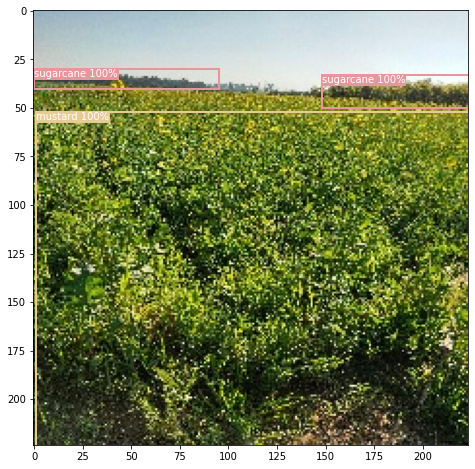

Image index:  83


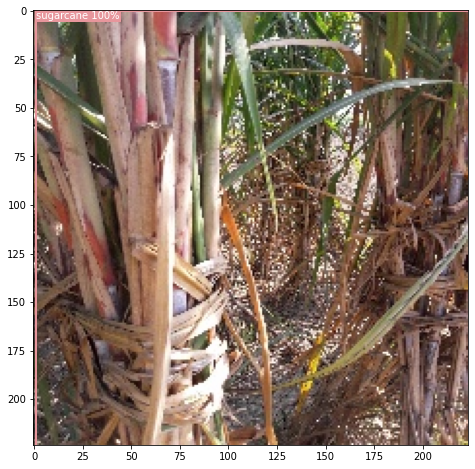

Image index:  68


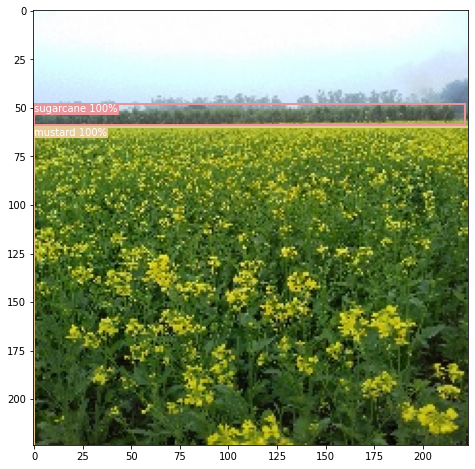

Image index:  22


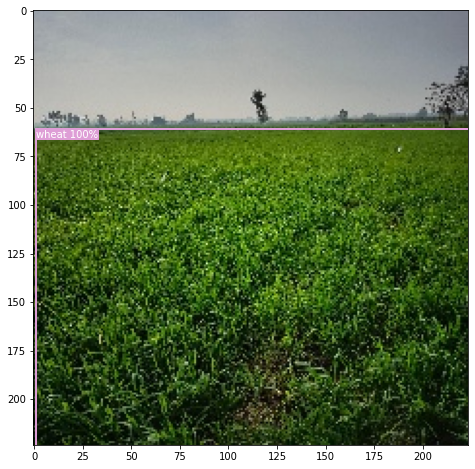

Image index:  389


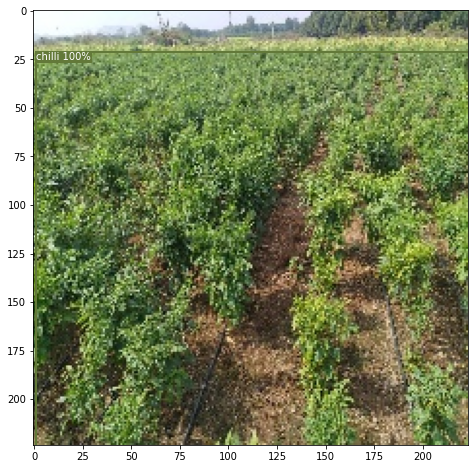

In [165]:
sample_images = 5

for _ in range(sample_images):
  
  x = random.randint(0, (len(dataset)-1))
  img, target = dataset[x]
  img = img.cpu().permute(1,2,0).numpy()
  boxes = target['boxes'].numpy()
  labels = target['labels'].numpy()
  scores = [1]*len(labels) #put dummy confidence 100% 
  print("Image index: ", x)
  plot_image(img, boxes, scores, labels, classes)

**Data Loader**

It will be helpful in dealing data in batches.



In [122]:
img_dir

'training_dataset/cleaned_resized_images'

In [166]:
BATCH_SIZE = 16

dataset = cropCustomDataset(img_dir, finaldf.copy(), classes, transforms=Transformation())
dataset_test = cropCustomDataset(img_dir, finaldf.copy(), classes, transforms=None)    
# define training and validation data loaders
def collate_fn(batch):
  return tuple(zip(*batch))

data_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn,shuffle=True, drop_last=True)

data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, collate_fn=collate_fn,shuffle=False, drop_last=True)

Intializing...
486
Dataset Prepared...
Intializing...
486
Dataset Prepared...


In [167]:
print(f"Total Number of batches in train is {len(data_loader)}")
print(f"Total Number of batches in train is {len(data_loader_test)}")

Total Number of batches in train is 30
Total Number of batches in train is 486


## Modeling

- Define configuartions as a constant values which we will be using for hyper-parameters.
- Load pretrained models with its weight
- change the last layer as per our number of classes
- Unfreeze last 5 layers from the end 

In [168]:
# Hyperparameters
RANDOM_SEED = 42
NUM_EPOCHS = 3
LR_MOMENTUM=0.9
LR = 0.005
LR_DECAY_RATE=0.001
LR_SCHED_STEP_SIZE = 0.15
LR_SCHED_GAMMA = 0.15

### Load pretrained model

In [169]:

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"We are using {device}")

#load pretrained model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
#number of classes
num_classes = len(classes)

#get the number of units in last layer
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to(device)


We are using cpu


/Users/ajitkumarsingh/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ajitkumarsingh/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

### Set cost function and optimizer

In [131]:
num_epochs = 5

# construct an optimizer
num_layers_to_unfreeze = 10
# Iterate through the model parameters in reverse order
for param in reversed(list(model.parameters())):
    param.requires_grad = True
    num_layers_to_unfreeze -= 1
    if num_layers_to_unfreeze < 0:
        param.requires_grad = False

#SGD optimizer
params = [p for p in model.parameters() if p.requires_grad]
print(len(params))
optimizer = torch.optim.SGD(params, lr=LR, momentum=LR_MOMENTUM, weight_decay=LR_DECAY_RATE)



10


## Model Finetuning

Define a function for finetuning the above model per epoch.

In [170]:
#training
def train_one_epoch(model, optimizer, data_loader, device):

  train_loss_list = []
  for idx, data in enumerate(data_loader):
    
    print(f"iterations : {idx+1}")
    optimizer.zero_grad()
    images, targets = data
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    losses = model(images, targets)
    loss = sum(loss for loss in losses.values())
    loss_val = loss.item()
    train_loss_list.append(loss_val)
    loss.backward()
    optimizer.step()


  return train_loss_list


## Model Evaluation

Let's train the model and note down train and validation loss simultaniously.

In [171]:
def evaluate(model, data_loader_test, device):
    
    val_loss_list = []


    for i, data in enumerate(data_loader_test):
        
        images, targets = data

        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        with torch.no_grad():
            losses = model(images, targets)

        loss = sum(loss for loss in losses.values())
        loss_val = loss.item()
        val_loss_list.append(loss_val)

    return val_loss_list

In [172]:
#train the model and note down both losses
loss_dict = {'train_loss': [], 'valid_loss': []}

for epoch in range(num_epochs):
  
  print(f"Epoch  no. {epoch+1}")

  # Train the model for per epoch
  train_loss_list = train_one_epoch(model, optimizer, data_loader, device)
  loss_dict['train_loss'].extend(train_loss_list)

  # evaluation
  valid_loss_list = evaluate(model, data_loader_test, device)
  loss_dict['valid_loss'].extend(valid_loss_list)


Epoch  no. 1
iterations : 1
iterations : 2
iterations : 3
iterations : 4
iterations : 5
iterations : 6
iterations : 7
iterations : 8
iterations : 9
iterations : 10
iterations : 11
iterations : 12
iterations : 13
iterations : 14
iterations : 15
iterations : 16
iterations : 17
iterations : 18
iterations : 19
iterations : 20
iterations : 21
iterations : 22
iterations : 23
iterations : 24
iterations : 25
iterations : 26
iterations : 27
iterations : 28
iterations : 29
iterations : 30
Epoch  no. 2
iterations : 1
iterations : 2
iterations : 3
iterations : 4
iterations : 5
iterations : 6
iterations : 7
iterations : 8
iterations : 9
iterations : 10
iterations : 11
iterations : 12


KeyboardInterrupt: 

### Plot loss curve 

In [173]:
#from train and valid loss list
def plot_loss(train_loss, valid_loss):

    figure_1, train_ax = plt.subplots()
    figure_2, valid_ax = plt.subplots()

    train_ax.plot(train_loss, color='blue')
    train_ax.set_xlabel('Iterations')
    train_ax.set_ylabel('Training Loss')

    valid_ax.plot(valid_loss, color='red')
    valid_ax.set_xlabel('Iterations')
    valid_ax.set_ylabel('Validation loss')
    

In [174]:
loss_dict['train_loss']

[3.000865936279297,
 2.956571578979492,
 3.176560640335083,
 3.0383715629577637,
 2.9865424633026123,
 3.4679434299468994,
 3.0685760974884033,
 3.0120203495025635,
 3.168353319168091,
 3.3014066219329834,
 3.17866849899292,
 3.3947417736053467,
 3.587977170944214,
 3.101013422012329,
 3.1939873695373535,
 2.918888807296753,
 3.165968894958496,
 3.0265440940856934,
 2.913893938064575,
 3.231081008911133,
 3.739820957183838,
 2.8707950115203857,
 2.944709300994873,
 2.9929561614990234,
 2.9727838039398193,
 3.5631558895111084,
 2.925391674041748,
 3.026324510574341,
 2.961430311203003,
 3.0299596786499023]

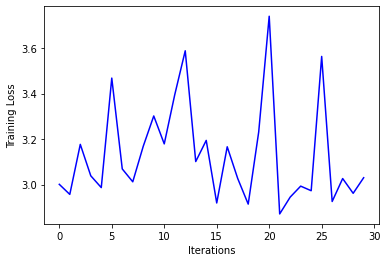

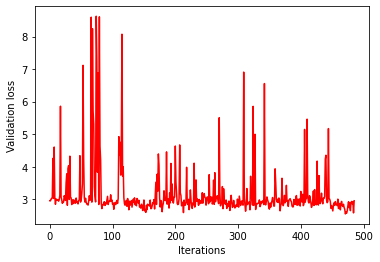

In [181]:
plot_loss(loss_dict['train_loss'], loss_dict['valid_loss'])

## Model Testing

In [176]:
#for making inference on per image level
def inference(img, model, detection_threshold=0.26):
  
  model.eval()

  img = img.to(device)
  outputs = model([img])
  return outputs

## Output Decoder

Implementing Non-Max Supression to get relevant bouding boxes.

In [177]:
def decode_output(output):
    bbs = output['boxes'].cpu().detach().numpy().astype(np.uint16)
    labels = np.array([i for i in output['labels'].cpu().detach().numpy()])
    confs = output['scores'].cpu().detach().numpy()
    idxs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.001)
    bbs, confs, labels = [tensor[idxs] for tensor in [bbs, confs, labels]]
    if len(idxs) == 1:
        bbs, confs, labels = [np.array([tensor]) for tensor in [bbs, confs, labels]]
    return bbs.tolist(), confs.tolist(), labels.tolist()


Download an image from internet and test it out

In [178]:
!wget -O sample_image.jpg "https://cdn.britannica.com/67/125067-050-F318A0E6/Sugarcane.jpg"

--2023-10-17 10:56:50--  https://cdn.britannica.com/67/125067-050-F318A0E6/Sugarcane.jpg
Resolving cdn.britannica.com (cdn.britannica.com)... failed: nodename nor servname provided, or not known.
wget: unable to resolve host address 'cdn.britannica.com'


In [179]:
boxes

array([[  1.,  21., 224., 224.]], dtype=float32)

In [180]:
image = cv2.imread("sample_image.jpg")
#normalize img
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
image /= 255.0
image = torch.from_numpy(image).permute(2,0,1)
image = image.to(device)

#get predictions
outputs = inference(image, model)[0]

boxes, scores, labels = decode_output(outputs)
#plot the prediction
image = image.squeeze(0).cpu().permute(1,2,0).numpy()
plot_image(image, boxes, scores, labels, classes)


error: OpenCV(4.8.0) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


## Save Weights

In [41]:
#save model's weight
torch.save(model.state_dict(), 'model_weights.pth')

#save model 
torch.save(model, 'entire_model.pth')